In [86]:
from __future__ import division
from __future__ import print_function
from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout

In [162]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import tensorflow as tf
import random
import os
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Collecting Data - Function for loading the data from local drive

In [128]:
def load_dataset(data_path, seed=1):


    path_dataset = os.path.join(data_path, 'aclImdb')

    # Training data
    train_txt = []
    train_labels = []
    for category in ['pos', 'neg']:
        train_path = os.path.join(path_dataset, 'train', category)
        train_lst = sorted(os.listdir(train_path))
        for name in train_lst:
            if name.endswith('.txt'):
                with open(os.path.join(train_path, name)) as file:
                    train_txt.append(file.read())
                binary_train = (0 if category == 'neg' else 1)    
                train_labels.append(binary_train)

    # Same as the above but this time for test data.
    test_txt = []
    test_labels = []
    for category in ['pos', 'neg']:
        test_path = os.path.join(path_dataset, 'test', category)
        test_lst = sorted(os.listdir(test_path))
        for name in test_lst:
            if name.endswith('.txt'):
                with open(os.path.join(test_path, name)) as file:
                    test_txt.append(file.read())
                binary_test = (0 if category == 'neg' else 1)    
                test_labels.append(binary_test)

    # Mix around the traning data and labels.
    random.seed(seed)
    random.shuffle(train_txt)
    random.seed(seed)
    random.shuffle(train_labels)

    return ((train_txt, np.array(train_labels)),
            (test_txt, np.array(test_labels)))



# Exploratory Data Analysis - understand the data and its distribution

In [131]:
num_words = [len(s.split()) for s in sample[0][0]]
np.median(num_words)

174.0

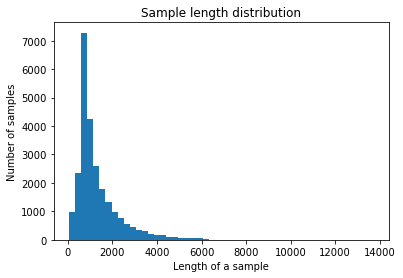

In [132]:
plt.hist([len(s) for s in sample[0][0]], 50)
plt.xlabel('Length of a sample')
plt.ylabel('Number of samples')
plt.title('Sample length distribution')
plt.show()

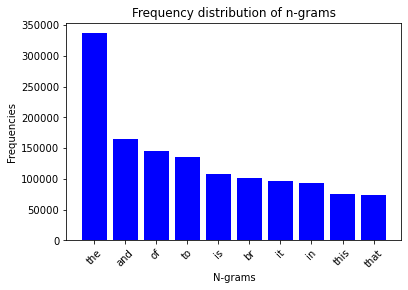

In [133]:
sample_texts = sample[0][0]
ngram_range=(1, 2)
num_ngrams=10

## Transforming words into a matrix of vectors for analysis 
arg = {'ngram_range': (1, 1), 
          'dtype': 'int32',
          'strip_accents': 'unicode',
          'decode_error': 'replace',
          'analyzer': 'word',}
          
vectorizer = CountVectorizer(**arg)
vectorized_texts = vectorizer.fit_transform(sample_texts)

# This is the list of all n-grams in the index order from the vocabulary.
all_ngrams = list(vectorizer.get_feature_names())
num_ngrams = min(num_ngrams, len(all_ngrams))
# ngrams = all_ngrams[:num_ngrams]

# Add up the counts per n-gram ie. column-wise
all_counts = vectorized_texts.sum(axis=0).tolist()[0]

# Sort n-grams and counts by frequency and get top `num_ngrams` ngrams.
ngram_count = sorted(zip(all_counts, all_ngrams), reverse=True)
all_counts, all_ngrams = zip(*[(c, n) for c, n in ngram_count])
ngrams = list(all_ngrams)[:num_ngrams]
counts = list(all_counts)[:num_ngrams]

idx = np.arange(num_ngrams)
plt.bar(idx, counts, width=0.8, color='b')
plt.xlabel('N-grams')
plt.ylabel('Frequencies')
plt.title('Frequency distribution of n-grams')
plt.xticks(idx, ngrams, rotation=45)
plt.show()

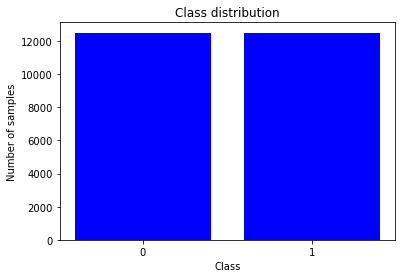

In [138]:
path_dataset = os.path.join('/Users/student/Desktop/', 'aclImdb')
txt = []
labels = []
for category in ['pos', 'neg']:
    train_path = os.path.join(path_dataset, 'train', category)
    train_lst = sorted(os.listdir(train_path))
    for name in train_lst:
        if name.endswith('.txt'):
            with open(os.path.join(train_path, name)) as file:
                txt.append(file.read())
            binary_train = (0 if category == 'neg' else 1)    
            labels.append(binary_train)

num_classes = max(labels) + 1
count_map = Counter(labels)
counts = [count_map[i] for i in range(num_classes)]
idx = np.arange(num_classes)
plt.bar(idx, counts, width=0.8, color='b')
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Class distribution')
plt.xticks(idx, idx)
plt.show()

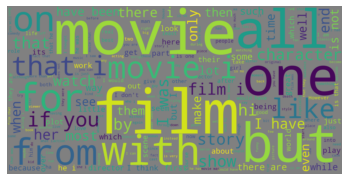

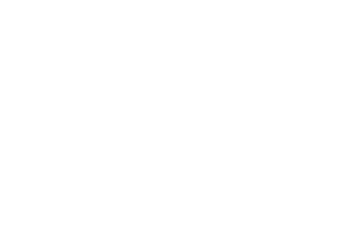

In [163]:
stop_words = ['in', 'of', 'at', 'a', 'the','or','this','it','and','to','be','as']

# All reviews from data
text = ' '.join(sample[0][0]) 

# limit the word count and set the stopwords
wordcount = 500
stopwords = set(stop_words)
stopwords.add("br")

# generate wordcloud
wc = WordCloud(scale=5, 
               background_color="grey", 
               max_words=wordcount, 
               stopwords=stopwords)
wc.generate(text)

# show the wordcloud as output
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure()
plt.axis("off")
plt.show()

# ML Model

In [121]:
def mlp(layers, units, dropout_rate, input_shape, num_classes):

    op_units, op_activation = (1,'sigmoid')
    model = models.Sequential()
    model.add(Dropout(rate=dropout_rate, input_shape=input_shape))

    for _ in range(layers-1):
        model.add(Dense(units=units, activation='relu'))
        model.add(Dropout(rate=dropout_rate))

    model.add(Dense(units=op_units, activation=op_activation))
    return model

In [120]:
sample = load_dataset('/Users/student/Desktop/')

In [123]:
# Vectorization parameters
# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)

# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 2  
 
def ngram_vectorize(train_texts, train_labels, val_texts):

    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
    }
    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)

    # Vectorize validation texts.
    x_val = vectorizer.transform(val_texts)

    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype('float32')
    x_val = selector.transform(x_val).astype('float32')
    return x_train, x_val

# Learning - Training the model

In [124]:
def train_model(data, learning_rate=1e-3, epochs=1000, batch_size=128, layers=2, units=64, dropout_rate=0.2):
    
    # Split data into the four variables.
    (train_texts, train_labels), (val_texts, val_labels) = data

    # Vectorise texts.
    x_train, x_val = ngram_vectorize(train_texts, train_labels, val_texts)
    num_classes = 2
    
    # Model instance.
    model = mlp(layers=layers,
                units=units,
                dropout_rate=dropout_rate,
                input_shape=x_train.shape[1:],
                num_classes=num_classes)

    # Learning parameters.
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    # Compile model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])

    # Callback - Stop training if loss does not increase in two tries consecutively
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)]

    # Train & validate model.
    history = model.fit(
            x_train,
            train_labels,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(x_val, val_labels),
            verbose=2,  # Logs once per epoch.
            batch_size=batch_size)

    # Print results.
    history = history.history
    print('Validation accuracy: {acc}, loss: {loss}'.format(acc=history['val_acc'][-1], loss=history['val_loss'][-1]))

    # Save model.
    model.save('IMDb_mlp_model.h5')
    return history['val_acc'][-1], history['val_loss'][-1]

In [145]:
final_model = train_model(sample)

//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:1799: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


Train on 25000 samples, validate on 25000 samples
Epoch 1/1000
25000/25000 - 34s - loss: 0.4729 - acc: 0.8495 - val_loss: 0.3235 - val_acc: 0.8876
Epoch 2/1000
25000/25000 - 41s - loss: 0.2321 - acc: 0.9214 - val_loss: 0.2508 - val_acc: 0.9016
Epoch 3/1000
25000/25000 - 35s - loss: 0.1691 - acc: 0.9410 - val_loss: 0.2332 - val_acc: 0.9059
Epoch 4/1000
25000/25000 - 38s - loss: 0.1365 - acc: 0.9523 - val_loss: 0.2304 - val_acc: 0.9054
Epoch 5/1000
25000/25000 - 33s - loss: 0.1117 - acc: 0.9628 - val_loss: 0.2321 - val_acc: 0.9045
Epoch 6/1000
25000/25000 - 33s - loss: 0.0944 - acc: 0.9704 - val_loss: 0.2386 - val_acc: 0.9034
Validation accuracy: 0.9033600091934204, loss: 0.23859093258142472
